# Introduction: Problems in recurrent VGG16 

In this notebook, I show some problems I met when I try to recurrent VGG16 performence in CalTech101 


performence:
![performence in CalTech101](https://www.robots.ox.ac.uk/~vgg/research/very_deep/images/table_other.png)

# Training part 

below are some issues I think may effect accuracy.


## Problem 1: How to use dataset: CalTech 101

In the original text, the description of datatest:

In this section, we present the image classification results achieved by the described
ConvNet architectures on the ILSVRC-2012 dataset (which was used for ILSVRC 2012–2014 challenges). The dataset includes images of 1000 classes, and is split into three sets: training (1.3M
images), validation (50K images), and testing (100K images with held-out class labels).

unfortunately, I do not see any description of CalTech in original paper.

But in CalTech website, they said :

How to use the dataset
If you are using the Caltech 101 dataset for testing your recognition algorithm you should try and make your results comparable to the results of others. We suggest training and testing on fixed number of pictures and repeating the experiment with different random selections of pictures in order to obtain error bars. Popular number of training images: 1, 3, 5, 10, 15, 20, 30. Popular numbers of testing images: 20, 30. See also the discussion below.
When you report your results please keep track of which images you used and which were misclassified. We will soon publish a more detailed experimental protocol that allows you to report those details. See the Discussion section for more details.

[CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). 

There are about 40 to 800 images in each category. If we use the ratio in original paper: (26 : 1 : 2), some test sets only have 2 images, that is unreasonable smell. If we follow the seggustion of Caltech website, the traing set may too smell. below is the number of images in some classes when I set the ratio (5, 2.5, 2.5)

In [1]:
import os
import math
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

traindir = 'data/CalTech101(50, 25, 25)/train/'
validdir = 'data/CalTech101(50, 25, 25)/val/'
testdir = 'data/CalTech101(50, 25, 25)/test/'
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])



# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')
# Dataframe of training images
image_df = pd.DataFrame({'category': img_categories,'height': hs,'width': ws})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

cat_df.tail()
print (cat_df)

        category  n_train  n_valid  n_test
1      airplanes      400      200     200
65    Motorbikes      399      199     200
36         Faces      217      108     110
37    Faces_easy      217      108     110
94         watch      119       59      61
..           ...      ...      ...     ...
97      wild_cat       17        8       9
73      platypus       17        8       9
7      binocular       16        8       9
63     metronome       16        8       8
50  inline_skate       15        7       9

[101 rows x 4 columns]


## Problem 2: Batch size and iteration 



In the original text, the description of hypeparameters:

The batch size was set to 256, momentum to 0.9. The training was regularised by weight decay (the L2 penalty multiplier set to 5 · 10−4) and dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).
The learning rate was initially set to 10−2, and then decreased by a factor of 10 when the validation
set accuracy stopped improving. In total, the learning rate was decreased 3 times, and the learning
was stopped after 370K iterations (74 epochs). 


unfortunately, I cannot set the batch size to 256, because when I set the batch size to 32 or bigger than 32, the GPU will out of memory 

Because the batch size and number of images is different, the number of iterations will change.


## Problem 3: initialisation 


In the original text, the description of initialisation:

The initialisation of the network weights is important, since bad initialisation can stall learning due
to the instability of gradient in deep nets. To circumvent this problem, we began with training
the configuration A (Table 1), shallow enough to be trained with random initialisation. Then, when
training deeper architectures, we initialised the first four convolutional layers and the last three fullyconnected layers with the layers of net A (the intermediate layers were initialised randomly). We did
not decrease the learning rate for the pre-initialised layers, allowing them to change during learning.
For random initialisation (where applicable), we sampled the weights from a normal distribution
with the zero mean and 10−2 variance. The biases were initialised with zero. It is worth noting that
after the paper submission we found that it is possible to initialise the weights without pre-training
by using the random initialisation procedure of Glorot & Bengio (2010).

(The configuration A is VGG11)
It is easy to understand the step of random initialisation, But the problem is how to shallow enough pre-train the first four convolutional layers and the last three fullyconnected layers. How to judge it is enough. 

Previously, I just use the initialisation function from [Pytorch VGG model](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py). 
code in below



In [2]:
def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

## Problem 4: Training image size 


In the original text, the description of image size:

Training image size. Let S be the smallest side of an isotropically-rescaled training image, from
which the ConvNet input is cropped (we also refer to S as the training scale). While the crop size
is fixed to 224 × 224, in principle S can take on any value not less than 224: for S = 224 the crop
will capture whole-image statistics, completely spanning the smallest side of a training image; for
S ≫ 224 the crop will correspond to a small part of the image, containing a small object or an object
part.
We consider two approaches for setting the training scale S. The first is to fix S, which corresponds
to single-scale training (note that image content within the sampled crops can still represent multiscale image statistics). In our experiments, we evaluated models trained at two fixed scales: S =
256 (which has been widely used in the prior art (Krizhevsky et al., 2012; Zeiler & Fergus, 2013;
Sermanet et al., 2014)) and S = 384. Given a ConvNet configuration, we first trained the network
using S = 256. To speed-up training of the S = 384 network, it was initialised with the weights
pre-trained with S = 256, and we used a smaller initial learning rate of 10−3
.
The second approach to setting S is multi-scale training, where each training image is individually
rescaled by randomly sampling S from a certain range [Smin, Smax] (we used Smin = 256 and
Smax = 512). Since objects in images can be of different size, it is beneficial to take this into account
during training. This can also be seen as training set augmentation by scale jittering, where a single model is trained to recognise objects over a wide range of scales. For speed reasons, we trained
multi-scale models by fine-tuning all layers of a single-scale model with the same configuration,
pre-trained with fixed S = 384.

Now I understand randomly sampling, but I found the size of images in imagenet and CalTech 101 is different. the images in imagenet are more bigger. 
"The average image resolution on ImageNet is 469x387 pixels, normally there is a pre-processing that samples them to 256x256 as @Prune said." Maybe not true. I found in [stackoverflow](https://stackoverflow.com/questions/36109886/what-is-the-resolution-of-an-image-in-imagenet-dataset/36191512)

And the images size in CalTech 101 in below. 



In [3]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                            \
            count        mean        std    min    25%    50%    75%    max   
category                                                                      
Faces       217.0  333.940092  32.170424  252.0  312.0  329.0  351.0  468.0   
Faces_easy  217.0  319.884793  24.825700  237.0  303.0  319.0  333.0  381.0   
Leopards    100.0  138.880000  24.161611  128.0  128.0  128.0  128.0  192.0   
Motorbikes  399.0  164.523810  19.361382  121.0  151.0  163.0  175.0  261.0   
accordion    27.0  260.592593  37.212756  191.0  234.0  258.0  300.0  300.0   

            width                                                            
            count        mean        std    min    25%    50%    75%    max  
category                                                                     
Faces       217.0  505.686636  48.604064  382.0  473.0  499.0  532.0  708.0  
Faces_easy  217.0  274.405530  16.853991  248.0  266.0  273.0  282.0  417.0  
Leopards    100.0  181.120000  24.161611  128.0  192.0  192.0  192.0  192.0  
Motorbikes  399.0  262.556391   3.620323  231.0  261.0  261.0  263.0  278.0  
accordion    27.0  278.407407  31.715392  209.0  259.5  300.0  300.0  300.0

Text(0.5, 1.0, 'Average Size Distribution')

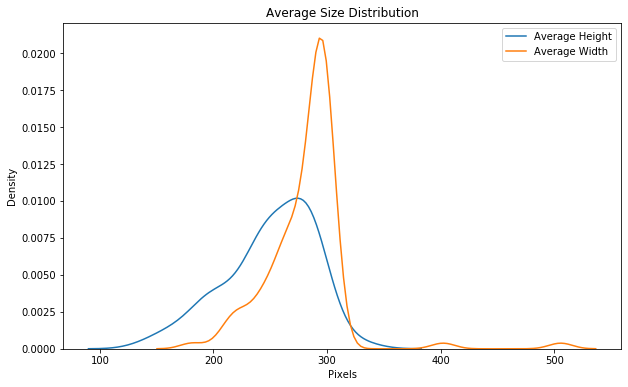

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

# Testing part 

below are some issues with testing

## Problem 1: How to implement  MULTI-SCALE EVALUATION

In the VGG paper, writer not only implement single-scale evaluation but also have multi-scale evaluaion.

In the original text, the description of test:

At test time, given a trained ConvNet and an input image, it is classified in the following way. First,
it is isotropically rescaled to a pre-defined smallest image side, denoted as Q (we also refer to it
as the test scale). We note that Q is not necessarily equal to the training scale S (as we will show
in Sect. 4, using several values of Q for each S leads to improved performance). Then, the network
is applied densely over the rescaled test image in a way similar to (Sermanet et al., 2014). Namely,
the fully-connected layers are first converted to convolutional layers (the first FC layer to a 7 × 7
conv. layer, the last two FC layers to 1 × 1 conv. layers). The resulting fully-convolutional net is
then applied to the whole (uncropped) image. The result is a class score map with the number of
channels equal to the number of classes, and a variable spatial resolution, dependent on the input
image size. Finally, to obtain a fixed-size vector of class scores for the image, the class score map is spatially averaged (sum-pooled). We also augment the test set by horizontal flipping of the images;
the soft-max class posteriors of the original and flipped images are averaged to obtain the final scores
for the image.
Since the fully-convolutional network is applied over the whole image, there is no need to sample
multiple crops at test time (Krizhevsky et al., 2012), which is less efficient as it requires network
re-computation for each crop. At the same time, using a large set of crops, as done by Szegedy et al.
(2014), can lead to improved accuracy, as it results in a finer sampling of the input image compared
to the fully-convolutional net. Also, multi-crop evaluation is complementary to dense evaluation due
to different convolution boundary conditions: when applying a ConvNet to a crop, the convolved
feature maps are padded with zeros, while in the case of dense evaluation the padding for the same
crop naturally comes from the neighbouring parts of an image (due to both the convolutions and
spatial pooling), which substantially increases the overall network receptive field, so more context
is captured. While we believe that in practice the increased computation time of multiple crops does
not justify the potential gains in accuracy, for reference we also evaluate our networks using 50 crops
per scale (5 × 5 regular grid with 2 flips), for a total of 150 crops over 3 scales, which is comparable
to 144 crops over 4 scales used by Szegedy et al. (2014).


First problems is also I heard about using a 1 * 1 filter can change FC layer to Conv layers, but I need some time to learn how to code it. Maybe I can do fixed scale evaluation at first.

Another thing is they use mean class recall to evaluate the performance in CalTech101.
At first time, I did not understand why they use this way to evaluate.
But I found CalTech101 actually has 102 image files include "BACKGROUND_Google". 
If delete this file the precision is equal to the recall score with this file.


## fixed training image size : 256
## fixed testing image size : 256


In [1]:
import torch
import numpy as np
import pandas as pd
import tqdm
import VGG
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import math
from tqdm import tqdm

batch_size = 32
num_workers = 0
def get_mean_and_std(dataloader):
    """
    Get the mean and std of a 3-channel image dataset 
    
    Args:
        dataloader: pytorch dataloader
    Returns:
        mean and std of the dataset
    """
    mean = []
    std = []
    
    total = 0
    r_running, g_running, b_running = 0, 0, 0
    r2_running, g2_running, b2_running = 0, 0, 0
    
    with torch.no_grad():
        for data, target in (dataloader):
            r, g, b = data[:,0 ,:, :], data[:, 1, :, :], data[:, 2, :, :]
            r2, g2, b2 = r**2, g**2, b**2
            
            # Sum up values to find mean
            r_running += r.sum().item()
            g_running += g.sum().item()
            b_running += b.sum().item()
            
            # Sum up squared values to find standard deviation
            r2_running += r2.sum().item()
            g2_running += g2.sum().item()
            b2_running += b2.sum().item()
            
            total += data.size(0)*data.size(2)*data.size(3)
    
    # Append the mean values 
    mean.extend([r_running/total, 
                 g_running/total, 
                 b_running/total])
    
    # Calculate standard deviation and append
    std.extend([
            math.sqrt((r2_running/total) - mean[0]**2),
            math.sqrt((g2_running/total) - mean[1]**2),
            math.sqrt((b2_running/total) - mean[2]**2)
            ])
    
    return mean, std

data_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
])

# choose the training and test datasets

train_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/train', transform=data_transforms)
valid_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/val', transform=data_transforms)
test_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/test', transform=data_transforms)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

train_mean, train_std = get_mean_and_std(train_loader)
valid_mean, valid_std = get_mean_and_std(valid_loader)
test_mean, test_std = get_mean_and_std(test_loader)

print (train_mean, train_std)
print (valid_mean, valid_std)
print (test_mean, test_std)

[0.5350910764237494, 0.5067089481625606, 0.4782639508581764] [0.29805370969169737, 0.2914208685582102, 0.3032802910678899]
[0.5353981323974902, 0.5065406293376725, 0.4732605698529412] [0.29882132940843714, 0.29152211769842495, 0.304049905122104]
[0.536962420713522, 0.5089351467446542, 0.47884879879381226] [0.29990629000847185, 0.2917782445908384, 0.3041200701866072]


In [2]:
import torch
import numpy as np
import pandas as pd

import VGG
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

train_normalize = transforms.Normalize(mean=train_mean,
                                       std=[1, 1, 1])

valid_normalize = transforms.Normalize(mean=valid_mean,
                                       std=[1, 1, 1])

test_normalize = transforms.Normalize(mean=test_mean,
                                       std=[1, 1, 1])

"""normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])"""

train_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        #normalize,
])


valid_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                      ])

test_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                     ])

# choose the training and test datasets
train_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/train', transform=train_transforms)
valid_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/val', transform=valid_transforms)
test_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/test', transform=test_transforms)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)



In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


# create a complete CNN
model = models.vgg16(num_classes=101)
                     
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
                     

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=5e-4)
lr_scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# number of epochs to train the model
n_epochs = 500

valid_loss_min = np.Inf # track change in validation loss

history = [] # record

In [6]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        
        #print (output)

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        
        
       
        train_loss += loss.item() * data.size(0)
        
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        train_acc += accuracy.item() * data.size(0)

             
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        
         # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * data.size(0)
       

    
    # calculate average losses

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_calTech.pt')
        valid_loss_min = valid_loss
    
    train_acc = train_acc / len(train_loader.dataset)
    print('\nTrain Accuracy: {:.6f}\n'.format(train_acc))
    valid_acc = valid_acc / len(valid_loader.dataset)
    print('\nValid Accuracy: {:.6f}\n'.format(valid_acc))
    history.append([train_loss, valid_loss, train_acc, valid_acc])
    
    lr_scheduler.step(valid_loss)
    

history = pd.DataFrame(history,columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])       


Epoch: 1 	Training Loss: 4.316897 	Validation Loss: 4.191970
Validation loss decreased (inf --> 4.191970).  Saving model ...

Train Accuracy: 0.085151


Valid Accuracy: 0.094118

Epoch: 2 	Training Loss: 4.211790 	Validation Loss: 4.173078
Validation loss decreased (4.191970 --> 4.173078).  Saving model ...

Train Accuracy: 0.091183


Valid Accuracy: 0.093647

Epoch: 3 	Training Loss: 4.200020 	Validation Loss: 4.176274

Train Accuracy: 0.094896


Valid Accuracy: 0.094118

Epoch: 4 	Training Loss: 4.198456 	Validation Loss: 4.162250
Validation loss decreased (4.173078 --> 4.162250).  Saving model ...

Train Accuracy: 0.085615


Valid Accuracy: 0.094118

Epoch: 5 	Training Loss: 4.194568 	Validation Loss: 4.169829

Train Accuracy: 0.093271


Valid Accuracy: 0.094118

Epoch: 6 	Training Loss: 4.192535 	Validation Loss: 4.141707
Validation loss decreased (4.162250 --> 4.141707).  Saving model ...

Train Accuracy: 0.096752


Valid Accuracy: 0.093647

Epoch: 7 	Training Loss: 4.153419 	Vali

Epoch: 50 	Training Loss: 1.956830 	Validation Loss: 1.594298
Validation loss decreased (1.603228 --> 1.594298).  Saving model ...

Train Accuracy: 0.512993


Valid Accuracy: 0.590588

Epoch: 51 	Training Loss: 1.985246 	Validation Loss: 1.685935

Train Accuracy: 0.505568


Valid Accuracy: 0.584000

Epoch: 52 	Training Loss: 1.953013 	Validation Loss: 1.616576

Train Accuracy: 0.515081


Valid Accuracy: 0.586824

Epoch: 53 	Training Loss: 1.890531 	Validation Loss: 1.456672
Validation loss decreased (1.594298 --> 1.456672).  Saving model ...

Train Accuracy: 0.532251


Valid Accuracy: 0.632000

Epoch: 54 	Training Loss: 1.885470 	Validation Loss: 1.580722

Train Accuracy: 0.532715


Valid Accuracy: 0.608941

Epoch: 55 	Training Loss: 1.902639 	Validation Loss: 1.539672

Train Accuracy: 0.525290


Valid Accuracy: 0.600000

Epoch: 56 	Training Loss: 1.825936 	Validation Loss: 1.457783

Train Accuracy: 0.539443


Valid Accuracy: 0.621647

Epoch: 57 	Training Loss: 1.786601 	Validation Los

Epoch: 110 	Training Loss: 1.069022 	Validation Loss: 1.131014

Train Accuracy: 0.719722


Valid Accuracy: 0.705882

Epoch: 111 	Training Loss: 1.025469 	Validation Loss: 1.165074

Train Accuracy: 0.737355


Valid Accuracy: 0.709647

Epoch: 112 	Training Loss: 1.031515 	Validation Loss: 1.230404

Train Accuracy: 0.731090


Valid Accuracy: 0.685647

Epoch: 113 	Training Loss: 1.055810 	Validation Loss: 1.110381
Validation loss decreased (1.130726 --> 1.110381).  Saving model ...

Train Accuracy: 0.725290


Valid Accuracy: 0.706353

Epoch: 114 	Training Loss: 1.031035 	Validation Loss: 1.101319
Validation loss decreased (1.110381 --> 1.101319).  Saving model ...

Train Accuracy: 0.743155


Valid Accuracy: 0.716706

Epoch: 115 	Training Loss: 1.004406 	Validation Loss: 1.174914

Train Accuracy: 0.744316


Valid Accuracy: 0.708706

Epoch: 116 	Training Loss: 1.028928 	Validation Loss: 1.178994

Train Accuracy: 0.739443


Valid Accuracy: 0.707294

Epoch: 117 	Training Loss: 1.007762 	Valida

Epoch: 173 	Training Loss: 0.465506 	Validation Loss: 0.999330

Train Accuracy: 0.876102


Valid Accuracy: 0.780706

Epoch: 174 	Training Loss: 0.498308 	Validation Loss: 0.959890

Train Accuracy: 0.868910


Valid Accuracy: 0.775059

Epoch: 175 	Training Loss: 0.494300 	Validation Loss: 0.963733

Train Accuracy: 0.870998


Valid Accuracy: 0.778353

Epoch: 176 	Training Loss: 0.473865 	Validation Loss: 0.978885

Train Accuracy: 0.879350


Valid Accuracy: 0.777412

Epoch: 177 	Training Loss: 0.451380 	Validation Loss: 1.007184

Train Accuracy: 0.885847


Valid Accuracy: 0.772706

Epoch: 178 	Training Loss: 0.508980 	Validation Loss: 0.963025

Train Accuracy: 0.864269


Valid Accuracy: 0.772706

Epoch   178: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 179 	Training Loss: 0.458300 	Validation Loss: 0.973126

Train Accuracy: 0.878886


Valid Accuracy: 0.771294

Epoch: 180 	Training Loss: 0.440244 	Validation Loss: 0.959279

Train Accuracy: 0.888399


Valid Accuracy: 0.776941

Ep

Epoch: 240 	Training Loss: 0.431894 	Validation Loss: 0.969824

Train Accuracy: 0.885151


Valid Accuracy: 0.774118

Epoch: 241 	Training Loss: 0.451283 	Validation Loss: 0.963550

Train Accuracy: 0.879814


Valid Accuracy: 0.776941

Epoch: 242 	Training Loss: 0.478043 	Validation Loss: 0.967571

Train Accuracy: 0.874478


Valid Accuracy: 0.773176

Epoch: 243 	Training Loss: 0.426868 	Validation Loss: 0.966266

Train Accuracy: 0.885847


Valid Accuracy: 0.776000

Epoch: 244 	Training Loss: 0.483666 	Validation Loss: 0.973428

Train Accuracy: 0.871694


Valid Accuracy: 0.772706

Epoch: 245 	Training Loss: 0.467067 	Validation Loss: 0.962967

Train Accuracy: 0.870302


Valid Accuracy: 0.776000

Epoch: 246 	Training Loss: 0.448577 	Validation Loss: 0.960178

Train Accuracy: 0.878654


Valid Accuracy: 0.776000

Epoch: 247 	Training Loss: 0.480358 	Validation Loss: 0.958946

Train Accuracy: 0.872622


Valid Accuracy: 0.776000

Epoch: 248 	Training Loss: 0.461615 	Validation Loss: 0.951732



Epoch: 310 	Training Loss: 0.461403 	Validation Loss: 0.951921

Train Accuracy: 0.878886


Valid Accuracy: 0.772706

Epoch: 311 	Training Loss: 0.437291 	Validation Loss: 0.960084

Train Accuracy: 0.882831


Valid Accuracy: 0.776000

Epoch: 312 	Training Loss: 0.470762 	Validation Loss: 0.960959

Train Accuracy: 0.876566


Valid Accuracy: 0.778824

Epoch: 313 	Training Loss: 0.469831 	Validation Loss: 0.959670

Train Accuracy: 0.875174


Valid Accuracy: 0.775059

Epoch: 314 	Training Loss: 0.445699 	Validation Loss: 0.960207

Train Accuracy: 0.879814


Valid Accuracy: 0.774588

Epoch: 315 	Training Loss: 0.465978 	Validation Loss: 0.973670

Train Accuracy: 0.876102


Valid Accuracy: 0.774118

Epoch: 316 	Training Loss: 0.446067 	Validation Loss: 0.965008

Train Accuracy: 0.881903


Valid Accuracy: 0.774118

Epoch: 317 	Training Loss: 0.431077 	Validation Loss: 0.945548

Train Accuracy: 0.884687


Valid Accuracy: 0.779294

Epoch: 318 	Training Loss: 0.472593 	Validation Loss: 0.962281



Epoch: 380 	Training Loss: 0.470602 	Validation Loss: 0.961497

Train Accuracy: 0.871462


Valid Accuracy: 0.771294

Epoch: 381 	Training Loss: 0.472257 	Validation Loss: 0.968853

Train Accuracy: 0.879814


Valid Accuracy: 0.776000

Epoch: 382 	Training Loss: 0.437479 	Validation Loss: 0.962875

Train Accuracy: 0.884687


Valid Accuracy: 0.776471

Epoch: 383 	Training Loss: 0.464405 	Validation Loss: 0.969019

Train Accuracy: 0.878654


Valid Accuracy: 0.776471

Epoch: 384 	Training Loss: 0.443225 	Validation Loss: 0.965521

Train Accuracy: 0.886079


Valid Accuracy: 0.776471

Epoch: 385 	Training Loss: 0.450832 	Validation Loss: 0.968068

Train Accuracy: 0.883759


Valid Accuracy: 0.779294

Epoch: 386 	Training Loss: 0.481565 	Validation Loss: 0.967929

Train Accuracy: 0.874246


Valid Accuracy: 0.778353

Epoch: 387 	Training Loss: 0.463005 	Validation Loss: 0.952919

Train Accuracy: 0.873782


Valid Accuracy: 0.780235

Epoch: 388 	Training Loss: 0.434565 	Validation Loss: 0.954345



Epoch: 450 	Training Loss: 0.464650 	Validation Loss: 0.962360

Train Accuracy: 0.875174


Valid Accuracy: 0.775059

Epoch: 451 	Training Loss: 0.459853 	Validation Loss: 0.964098

Train Accuracy: 0.878190


Valid Accuracy: 0.776000

Epoch: 452 	Training Loss: 0.465175 	Validation Loss: 0.955580

Train Accuracy: 0.874246


Valid Accuracy: 0.776000

Epoch: 453 	Training Loss: 0.417414 	Validation Loss: 0.975438

Train Accuracy: 0.888399


Valid Accuracy: 0.774118

Epoch: 454 	Training Loss: 0.475686 	Validation Loss: 0.956225

Train Accuracy: 0.872390


Valid Accuracy: 0.775529

Epoch: 455 	Training Loss: 0.434011 	Validation Loss: 0.974893

Train Accuracy: 0.888167


Valid Accuracy: 0.771294

Epoch: 456 	Training Loss: 0.458459 	Validation Loss: 0.964627

Train Accuracy: 0.879118


Valid Accuracy: 0.770824

Epoch: 457 	Training Loss: 0.434891 	Validation Loss: 0.977298

Train Accuracy: 0.882831


Valid Accuracy: 0.770824

Epoch: 458 	Training Loss: 0.446663 	Validation Loss: 0.959642



In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')



plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
model.load_state_dict(torch.load('model_calTech.pt'))

In [ ]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        
        #print (output)

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        
        
       
        train_loss += loss.item() * data.size(0)
        
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        train_acc += accuracy.item() * data.size(0)

             
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        
         # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * data.size(0)
       

    
    # calculate average losses

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_calTech.pt')
        valid_loss_min = valid_loss
    
    train_acc = train_acc / len(train_loader.dataset)
    print('\nTrain Accuracy: {:.6f}\n'.format(train_acc))
    valid_acc = valid_acc / len(valid_loader.dataset)
    print('\nValid Accuracy: {:.6f}\n'.format(valid_acc))
    history.append([train_loss, valid_loss, train_acc, valid_acc])
    
    lr_scheduler.step(valid_loss)
    

history = pd.DataFrame(history,columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])       


Epoch: 1 	Training Loss: 0.495803 	Validation Loss: 0.928101
Validation loss decreased (0.939064 --> 0.928101).  Saving model ...

Train Accuracy: 0.867749


Valid Accuracy: 0.780235

Epoch: 2 	Training Loss: 0.465715 	Validation Loss: 0.941752

Train Accuracy: 0.881206


Valid Accuracy: 0.775529

Epoch: 3 	Training Loss: 0.503198 	Validation Loss: 0.923109
Validation loss decreased (0.928101 --> 0.923109).  Saving model ...

Train Accuracy: 0.875870


Valid Accuracy: 0.771765

Epoch: 4 	Training Loss: 0.509260 	Validation Loss: 0.941250

Train Accuracy: 0.866125


Valid Accuracy: 0.773176

Epoch: 5 	Training Loss: 0.498345 	Validation Loss: 0.946922

Train Accuracy: 0.868213


Valid Accuracy: 0.771294

Epoch: 6 	Training Loss: 0.488276 	Validation Loss: 0.920439
Validation loss decreased (0.923109 --> 0.920439).  Saving model ...

Train Accuracy: 0.868213


Valid Accuracy: 0.776471

Epoch: 7 	Training Loss: 0.517000 	Validation Loss: 0.940398

Train Accuracy: 0.871694


Valid Accuracy


Epoch: 70 	Training Loss: 0.465910 	Validation Loss: 0.938061

Train Accuracy: 0.877726


Valid Accuracy: 0.769882

Epoch: 71 	Training Loss: 0.517900 	Validation Loss: 0.942941

Train Accuracy: 0.867981


Valid Accuracy: 0.771294

Epoch: 72 	Training Loss: 0.511804 	Validation Loss: 0.927242

Train Accuracy: 0.867749


Valid Accuracy: 0.773647

Epoch: 73 	Training Loss: 0.502567 	Validation Loss: 0.939672

Train Accuracy: 0.873318


Valid Accuracy: 0.774118

Epoch: 74 	Training Loss: 0.512383 	Validation Loss: 0.934999

Train Accuracy: 0.864501


Valid Accuracy: 0.773647

Epoch: 75 	Training Loss: 0.476093 	Validation Loss: 0.919808
Validation loss decreased (0.920439 --> 0.919808).  Saving model ...

Train Accuracy: 0.878654


Valid Accuracy: 0.780235

Epoch: 76 	Training Loss: 0.523330 	Validation Loss: 0.931906

Train Accuracy: 0.864037


Valid Accuracy: 0.776000

Epoch: 77 	Training Loss: 0.495353 	Validation Loss: 0.944516

Train Accuracy: 0.867053


Valid Accuracy: 0.766118

Ep

Epoch: 139 	Training Loss: 0.489079 	Validation Loss: 0.950447

Train Accuracy: 0.876102


Valid Accuracy: 0.775059

Epoch: 140 	Training Loss: 0.497117 	Validation Loss: 0.933517

Train Accuracy: 0.867981


Valid Accuracy: 0.776941

Epoch: 141 	Training Loss: 0.473766 	Validation Loss: 0.943296

Train Accuracy: 0.871694


Valid Accuracy: 0.772235

Epoch: 142 	Training Loss: 0.485134 	Validation Loss: 0.932457

Train Accuracy: 0.875406


Valid Accuracy: 0.776000

Epoch: 143 	Training Loss: 0.516207 	Validation Loss: 0.931823

Train Accuracy: 0.862413


Valid Accuracy: 0.769882

Epoch: 144 	Training Loss: 0.503847 	Validation Loss: 0.927376

Train Accuracy: 0.871462


Valid Accuracy: 0.771294

Epoch: 145 	Training Loss: 0.540106 	Validation Loss: 0.944254

Train Accuracy: 0.859397


Valid Accuracy: 0.773647

Epoch: 146 	Training Loss: 0.481545 	Validation Loss: 0.929569

Train Accuracy: 0.875638


Valid Accuracy: 0.773176

Epoch: 147 	Training Loss: 0.531049 	Validation Loss: 0.921658



In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')



plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [3]:
import torch
import numpy as np
import pandas as pd

import VGG
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

train_normalize = transforms.Normalize(mean=train_mean,
                                       std=train_std)

valid_normalize = transforms.Normalize(mean=valid_mean,
                                       std=valid_std)

test_normalize = transforms.Normalize(mean=test_mean,
                                       std=test_std)

"""normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])"""

train_transforms = transforms.Compose([
        #transforms.Resize(size=256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        #normalize,
])


valid_transforms = transforms.Compose([
        #transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                      ])

test_transforms = transforms.Compose([
        #transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                     ])

# choose the training and test datasets
train_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/train', transform=train_transforms)
valid_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/val', transform=valid_transforms)
test_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/test', transform=test_transforms)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)



In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


# create a complete CNN
model = models.vgg16(num_classes=101)
                     
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=5e-4)
lr_scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# number of epochs to train the model
n_epochs = 200

valid_loss_min = np.Inf # track change in validation loss

history = [] # record

In [ ]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        
        #print (output)

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        
        
       
        train_loss += loss.item() * data.size(0)
        
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        train_acc += accuracy.item() * data.size(0)

             
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        
         # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * data.size(0)
       

    
    # calculate average losses

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_calTech2.pt')
        valid_loss_min = valid_loss
    
    train_acc = train_acc / len(train_loader.dataset)
    print('\nTrain Accuracy: {:.6f}\n'.format(train_acc))
    valid_acc = valid_acc / len(valid_loader.dataset)
    print('\nValid Accuracy: {:.6f}\n'.format(valid_acc))
    history.append([train_loss, valid_loss, train_acc, valid_acc])
    
    lr_scheduler.step(valid_loss)
    

history = pd.DataFrame(history,columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])       


Text(0.5, 1.0, 'Training and Validation Accuracy')

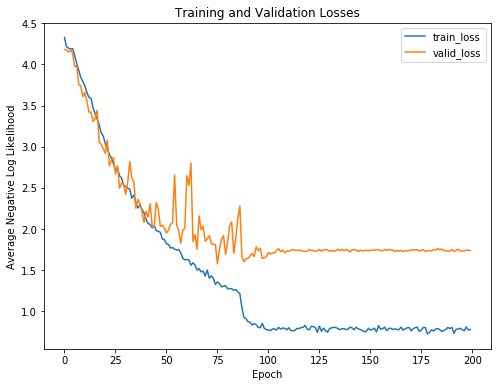

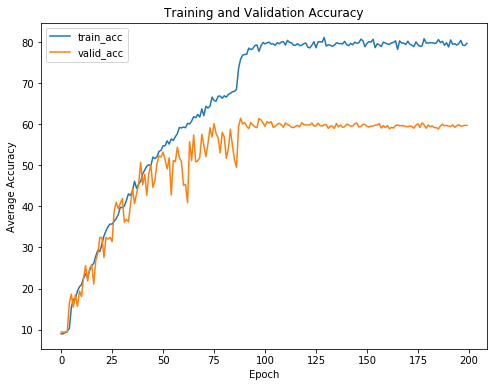

In [9]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')



plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

train_normalize = transforms.Normalize(mean=train_mean,
                                       std=train_std)

valid_normalize = transforms.Normalize(mean=valid_mean,
                                       std=valid_std)

test_normalize = transforms.Normalize(mean=test_mean,
                                       std=test_std)

"""normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])"""

train_transforms = transforms.Compose([
        #transforms.Resize(size=256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        #normalize,
])


valid_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                      ])

test_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize,
                                     ])

# choose the training and test datasets
train_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/train', transform=train_transforms)
valid_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/val', transform=valid_transforms)
test_data = datasets.ImageFolder('data/CalTech101(50, 25, 25)/test', transform=test_transforms)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True,
    num_workers=num_workers)



In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


# create a complete CNN
model = models.vgg16(num_classes=101)
                     
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=5e-4)
lr_scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# number of epochs to train the model
n_epochs = 200

valid_loss_min = np.Inf # track change in validation loss

history = [] # record

In [12]:
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
        
        #print (output)

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        
        
       
        train_loss += loss.item() * data.size(0)
        
        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        train_acc += accuracy.item() * data.size(0)

             
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        
         # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        valid_acc += accuracy.item() * data.size(0)
       

    
    # calculate average losses

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_calTech3.pt')
        valid_loss_min = valid_loss
    
    train_acc = train_acc / len(train_loader.dataset)
    print('\nTrain Accuracy: {:.6f}\n'.format(train_acc))
    valid_acc = valid_acc / len(valid_loader.dataset)
    print('\nValid Accuracy: {:.6f}\n'.format(valid_acc))
    history.append([train_loss, valid_loss, train_acc, valid_acc])
    
    lr_scheduler.step(valid_loss)
    

history = pd.DataFrame(history,columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])       


Epoch: 1 	Training Loss: 4.317397 	Validation Loss: 4.200243
Validation loss decreased (inf --> 4.200243).  Saving model ...

Train Accuracy: 0.082831


Valid Accuracy: 0.093647

Epoch: 2 	Training Loss: 4.206058 	Validation Loss: 4.192066
Validation loss decreased (4.200243 --> 4.192066).  Saving model ...

Train Accuracy: 0.096288


Valid Accuracy: 0.093647

Epoch: 3 	Training Loss: 4.207240 	Validation Loss: 4.201741

Train Accuracy: 0.090255


Valid Accuracy: 0.094118

Epoch: 4 	Training Loss: 4.198543 	Validation Loss: 4.174504
Validation loss decreased (4.192066 --> 4.174504).  Saving model ...

Train Accuracy: 0.094664


Valid Accuracy: 0.094118

Epoch: 5 	Training Loss: 4.204344 	Validation Loss: 4.170695
Validation loss decreased (4.174504 --> 4.170695).  Saving model ...

Train Accuracy: 0.095360


Valid Accuracy: 0.094118

Epoch: 6 	Training Loss: 4.197324 	Validation Loss: 4.181453

Train Accuracy: 0.097216


Valid Accuracy: 0.093647

Epoch: 7 	Training Loss: 4.198739 	Vali

Epoch: 53 	Training Loss: 2.087106 	Validation Loss: 1.673982

Train Accuracy: 0.486543


Valid Accuracy: 0.570824

Epoch: 54 	Training Loss: 2.065734 	Validation Loss: 1.700988

Train Accuracy: 0.487471


Valid Accuracy: 0.566588

Epoch: 55 	Training Loss: 2.038438 	Validation Loss: 1.563989
Validation loss decreased (1.673689 --> 1.563989).  Saving model ...

Train Accuracy: 0.502552


Valid Accuracy: 0.611765

Epoch: 56 	Training Loss: 1.992492 	Validation Loss: 1.651814

Train Accuracy: 0.505800


Valid Accuracy: 0.596706

Epoch: 57 	Training Loss: 1.959509 	Validation Loss: 1.549213
Validation loss decreased (1.563989 --> 1.549213).  Saving model ...

Train Accuracy: 0.518097


Valid Accuracy: 0.611294

Epoch: 58 	Training Loss: 1.943767 	Validation Loss: 1.516443
Validation loss decreased (1.549213 --> 1.516443).  Saving model ...

Train Accuracy: 0.519722


Valid Accuracy: 0.610353

Epoch: 59 	Training Loss: 1.888702 	Validation Loss: 1.550342

Train Accuracy: 0.534339


Valid A



Valid Accuracy: 0.726588

Epoch: 115 	Training Loss: 1.054641 	Validation Loss: 1.195368

Train Accuracy: 0.725754


Valid Accuracy: 0.705412

Epoch: 116 	Training Loss: 1.102530 	Validation Loss: 1.159852

Train Accuracy: 0.722274


Valid Accuracy: 0.702118

Epoch: 117 	Training Loss: 1.073410 	Validation Loss: 1.142807

Train Accuracy: 0.719490


Valid Accuracy: 0.706824

Epoch: 118 	Training Loss: 1.031045 	Validation Loss: 1.232117

Train Accuracy: 0.732251


Valid Accuracy: 0.700706

Epoch: 119 	Training Loss: 1.064662 	Validation Loss: 1.178188

Train Accuracy: 0.728074


Valid Accuracy: 0.703059

Epoch: 120 	Training Loss: 1.038193 	Validation Loss: 1.102917
Validation loss decreased (1.110790 --> 1.102917).  Saving model ...

Train Accuracy: 0.733643


Valid Accuracy: 0.723765

Epoch: 121 	Training Loss: 1.118453 	Validation Loss: 1.227416

Train Accuracy: 0.718329


Valid Accuracy: 0.699294

Epoch: 122 	Training Loss: 1.081585 	Validation Loss: 1.122831

Train Accuracy: 0.72

Epoch: 178 	Training Loss: 0.582518 	Validation Loss: 0.930972
Validation loss decreased (0.941716 --> 0.930972).  Saving model ...

Train Accuracy: 0.853132


Valid Accuracy: 0.768471

Epoch: 179 	Training Loss: 0.558995 	Validation Loss: 0.946547

Train Accuracy: 0.853364


Valid Accuracy: 0.774118

Epoch: 180 	Training Loss: 0.586175 	Validation Loss: 0.952234

Train Accuracy: 0.850812


Valid Accuracy: 0.767529

Epoch: 181 	Training Loss: 0.552114 	Validation Loss: 0.950816

Train Accuracy: 0.854988


Valid Accuracy: 0.764706

Epoch: 182 	Training Loss: 0.561080 	Validation Loss: 0.935067

Train Accuracy: 0.856613


Valid Accuracy: 0.774118

Epoch: 183 	Training Loss: 0.570880 	Validation Loss: 0.942474

Train Accuracy: 0.848028


Valid Accuracy: 0.768941

Epoch: 184 	Training Loss: 0.544501 	Validation Loss: 0.949256

Train Accuracy: 0.856148


Valid Accuracy: 0.771294

Epoch: 185 	Training Loss: 0.567849 	Validation Loss: 0.951251

Train Accuracy: 0.847332


Valid Accuracy: 0.774

Text(0.5, 1.0, 'Training and Validation Accuracy')

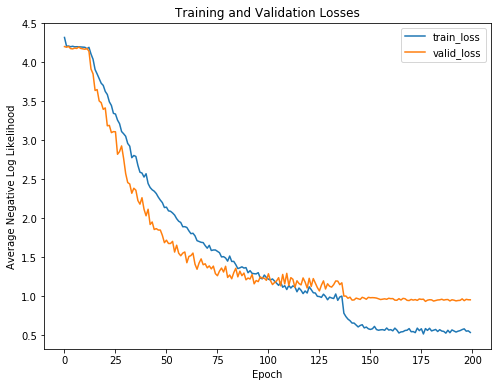

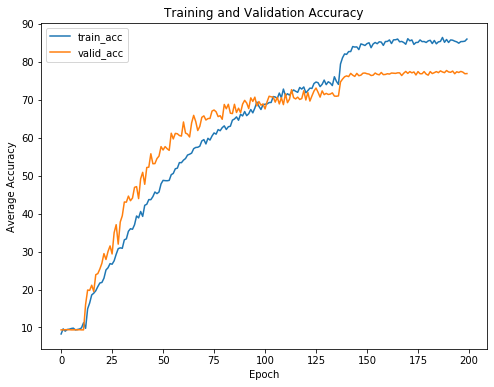

In [13]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')



plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')